# Preprocessing of individual datasets

Import packages... 
- [scanpy](https://scanpy.readthedocs.io/en/stable/index.html)


In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd

import gc
import os

In [67]:
WORKDIR="/workdir/dwm269/scMuscle2"
os.chdir(WORKDIR)

In [2]:
gc.enable()

In [3]:
DATADIR="/workdir/dwm269/scMuscle2/data/align_out"

Load metadata

In [18]:
meta = pd.read_csv("../scMuscle2_metadata_v1-0.csv")
meta = meta.loc[meta["include"],] # remove unwanted metadata
meta = meta[[x in ["fastq", "bam"] for x in meta["file.format"]]] # remove samples w/ download issues

meta = meta[[x in ["muscle", "tendon"] for x in meta["tissue"]]] # subset by tissue 
meta = meta[[x in ["Homo sapiens"] for x in meta["species"]]] # subset by species , "Mus musculus"
# meta = meta.iloc[[8,12,23,34,45],] # subset by row index

meta = meta[[x != "" for x in meta["GSM.accession"]]] # 
meta = meta[[x != "" for x in meta["sample"]]] # 

meta.index = list(range(0, len(meta))) # reset row indices
meta

,source.label,sample,description,tissue,subtissue,comments,include,ambient_decon,species,GSE.accession,...,sample.accession,SAMN.accession,file_checksum,other.accession,source,manuscript.doi,manuscript.pubmed,experiment.instrument,study.title,study.abstract
0,Nakajima 2021,1_iPS,"Human iPS cell line, 1231A3",tendon,iPSC,NaN,True,True,Homo sapiens,GSE156753,...,SRS7251319,SAMN15893659,NaN,NaN,"Najajima et al, Nature Communications, 20021",NaN,https://pubmed.ncbi.nlm.nih.gov/34408142/,Illumina HiSeq 2500,Grafting induced pluripotent stem cells-derive...,Self-renewal of tendons is rare since the vasc...
1,Nakajima 2021,2_PSM,iPS-derived presomitic mesoderm,tendon,iPSC,NaN,True,True,Homo sapiens,GSE156753,...,SRS7251320,SAMN15893658,NaN,NaN,"Najajima et al, Nature Communications, 20021",NaN,https://pubmed.ncbi.nlm.nih.gov/34408142/,Illumina HiSeq 2500,Grafting induced pluripotent stem cells-derive...,Self-renewal of tendons is rare since the vasc...
2,Nakajima 2021,3_SM,iPS-derived somitic mesoderm,tendon,iPSC,NaN,True,True,Homo sapiens,GSE156753,...,SRS7251321,SAMN15893657,NaN,NaN,"Najajima et al, Nature Communications, 20021",NaN,https://pubmed.ncbi.nlm.nih.gov/34408142/,Illumina HiSeq 2500,Grafting induced pluripotent stem cells-derive...,Self-renewal of tendons is rare since the vasc...
3,Nakajima 2021,4_SCL,iPS-derived sclerotome,tendon,iPSC,NaN,True,True,Homo sapiens,GSE156753,...,SRS7251322,SAMN15893656,NaN,NaN,"Najajima et al, Nature Communications, 20021",NaN,https://pubmed.ncbi.nlm.nih.gov/34408142/,Illumina HiSeq 2500,Grafting induced pluripotent stem cells-derive...,Self-renewal of tendons is rare since the vasc...
4,Nakajima 2021,5_SYN_day2,iPS-derived syndetome,tendon,iPSC,NaN,True,True,Homo sapiens,GSE156753,...,SRS7251323,SAMN15893654,NaN,NaN,"Najajima et al, Nature Communications, 20021",NaN,https://pubmed.ncbi.nlm.nih.gov/34408142/,Illumina HiSeq 2500,Grafting induced pluripotent stem cells-derive...,Self-renewal of tendons is rare since the vasc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Lee 2021,BTS_D7_2,Day 7 post Burn/Tenotomy with sham neurectomy ...,tendon,NaN,151bp R1; 28bp until poly(T),True,True,Homo sapiens,GSE163446,...,SRS7895118,SAMN17106058,NaN,NaN,"Lee et al, Nature Communications, 2021",NaN,https://pubmed.ncbi.nlm.nih.gov/34400627/,Illumina NovaSeq 6000,scRNA sequencing of cells harvested from the t...,scRNA sequencing was performed on cells harves...
79,Lee 2021,BTS_D7_3,Day 7 post Burn/Tenotomy with sham neurectomy ...,tendon,NaN,151bp R1; 28bp until poly(T),True,True,Homo sapiens,GSE163446,...,SRS7895119,SAMN17106057,NaN,NaN,"Lee et al, Nature Communications, 2021",NaN,https://pubmed.ncbi.nlm.nih.gov/34400627/,Illumina NovaSeq 6000,scRNA sequencing of cells harvested from the t...,scRNA sequencing was performed on cells harves...
80,Lee 2021,BTN_D7_1,Day 7 post Burn/Tenotomy with neurectomy injur...,tendon,NaN,151bp R1; 28bp until poly(T),True,True,Homo sapiens,GSE163446,...,SRS7895120,SAMN17106056,NaN,NaN,"Lee et al, Nature Communications, 2021",NaN,https://pubmed.ncbi.nlm.nih.gov/34400627/,Illumina NovaSeq 6000,scRNA sequencing of cells harvested from the t...,scRNA sequencing was performed on cells harves...
81,Lee 2021,BTN_D7_2,Day 7 post Burn/Tenotomy with neurectomy injur...,tendon,NaN,151bp R1; 28bp until poly(T),True,True,Homo sapiens,GSE163446,...,SRS7895121,SAMN17106065,NaN,NaN,"Lee et al, Nature Communications, 2021",NaN,https://pubmed.ncbi.nlm.nih.gov/34400627/,Illumina NovaSeq 6000,scRNA sequencing of cells harvested from the t...,scRNA sequencing was performed on cells harves...


In [19]:
meta.tissue.value_counts()

muscle    68
tendon    15
Name: tissue, dtype: int64

In [6]:
# Calculate the number of PCs that contain some proportion (default is 95%) of the variance
def npcs(
  ADATA,
  var_perc=0.95,
  reduction="pca"
):
    import numpy as np
    get_var = lambda i: np.var(ADATA.obsm[reduction][:,i])

    if ADATA.obsm[reduction] is None:
        print(f"Reduction {reduction}, not found!")
        return None
    else:
        var_tmp = [get_var(i) for i in list(range(0,ADATA.obsm[reduction].shape[1]))]
        var_cut = var_perc * np.sum(var_tmp)
        n_pcs = 0
        var_sum = 0
        while var_sum<var_cut and n_pcs<ADATA.obsm[reduction].shape[1]-1:
            var_sum = var_sum + var_tmp[n_pcs]
            n_pcs = n_pcs + 1

        return(n_pcs)

Read in count data & initialize anndata objects. ALso add metadata to each object

In [20]:
# try:
#     scm_list.index
# except:
scm_list = pd.Series(
    index = meta["GSM.accession"],
    data = [""]*meta.shape[0]
)

In [21]:
for i in range(0,meta.shape[0]):
    if os.path.exists(DATADIR+"/"+meta["GSM.accession"][i]+"/STARsolo/Solo.out/GeneFull/filtered/matrix.mtx.gz"):
        print("Sample: " + meta["GSM.accession"][i]) 
#         try:
        scm_list[i] = sc.read_10x_mtx(
                path=DATADIR+"/"+meta["GSM.accession"][i]+"/STARsolo/Solo.out/GeneFull/filtered", 
                var_names='gene_symbols',
                make_unique=True,
                cache=True
            )
          
        scm_list[i].var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

        for j in range(0,meta.shape[1]): #metadata features
            scm_list[i].obs[meta.columns[j]] = meta.iloc[i,j]

        scm_list[i].layers['counts'] = scm_list[i].X # save counts as a layer for future plotting

        print("     Loaded " + str(scm_list[i].shape[0]) + " cells and " + str(scm_list[i].shape[1]) + " genes...")
    else:
        print("Can't find counts for " + str(meta["GSM.accession"][i]) + "...")
#         except:
#             print("Exception with " + meta["sample"][i])

Sample: GSM4743488


/home/dwm269/miniconda3/envs/pyRNA4/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


     Loaded 4838 cells and 61860 genes...
Sample: GSM4743489
     Loaded 3151 cells and 61860 genes...
Sample: GSM4743490
     Loaded 3047 cells and 61860 genes...
Sample: GSM4743491
     Loaded 2500 cells and 61860 genes...
Sample: GSM4743492
     Loaded 2172 cells and 61860 genes...
Sample: GSM4743493
     Loaded 2642 cells and 61860 genes...
Sample: GSM4743494
     Loaded 2706 cells and 61860 genes...
Sample: GSM4743495
     Loaded 3199 cells and 61860 genes...
Sample: GSM5848681
     Loaded 5498 cells and 61860 genes...
Sample: GSM5848680
     Loaded 5875 cells and 61860 genes...
Sample: GSM5848679
     Loaded 6434 cells and 61860 genes...
Sample: GSM5848678
     Loaded 10062 cells and 61860 genes...
Sample: GSM4272893
     Loaded 2392 cells and 61860 genes...
Sample: GSM4272894
     Loaded 902 cells and 61860 genes...
Sample: GSM4272895
     Loaded 1667 cells and 61860 genes...
Sample: GSM4272896
     Loaded 381 cells and 61860 genes...
Sample: GSM4272897
     Loaded 2141 cells an

Add ambient-RNA-scrubbed counts

In [9]:
#TODO

In [22]:
gc.collect()

81972

QC filter and preprocess individual datasets

In [23]:
# gene/transcript, mito filters count filters
for i in range(0,meta.shape[0]):
    try:
        print(meta["GSM.accession"][i] + ': ' + str(scm_list[i].shape[0]) + " cells and " + str(scm_list[i].shape[1]) +' features...')  

        # Hard filters for feature and UMI counts
        sc.pp.filter_cells(
            scm_list[i],
            min_genes=500
        )
        sc.pp.filter_cells(
            scm_list[i], 
            min_counts=1000
        )
#         sc.pp.filter_cells(
#             scm_list[i], 
#             max_counts=50000
#         )

        # Hard filter for sparsely detected features
#         sc.pp.filter_genes(
#             scm_list[i],
#             min_cells=5
#         ) 

        scm_list[i].var['mito'] = scm_list[i].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(
            scm_list[i], 
            qc_vars=['mito'], 
            percent_top=None, 
            log1p=False, 
            inplace=True
        )  

        # QC filter(s)
        scm_list[i] = scm_list[i][scm_list[i].obs.pct_counts_mito < 40, :] 

        print('After filtering: ' + str(scm_list[i].shape[0]) + " cells and " + str(scm_list[i].shape[1]) +' features...')  
    
    except:
            print("Exception with " + meta["GSM.accession"][i])
        
    print(" ")

GSM4743488: 4838 cells and 61860 features...
After filtering: 3051 cells and 61860 features...
 
GSM4743489: 3151 cells and 61860 features...
After filtering: 1811 cells and 61860 features...
 
GSM4743490: 3047 cells and 61860 features...
After filtering: 2233 cells and 61860 features...
 
GSM4743491: 2500 cells and 61860 features...
After filtering: 1869 cells and 61860 features...
 
GSM4743492: 2172 cells and 61860 features...
After filtering: 1936 cells and 61860 features...
 
GSM4743493: 2642 cells and 61860 features...
After filtering: 2484 cells and 61860 features...
 
GSM4743494: 2706 cells and 61860 features...
After filtering: 2577 cells and 61860 features...
 
GSM4743495: 3199 cells and 61860 features...
After filtering: 2531 cells and 61860 features...
 
GSM5848681: 5498 cells and 61860 features...
After filtering: 5274 cells and 61860 features...
 
GSM5848680: 5875 cells and 61860 features...
After filtering: 5233 cells and 61860 features...
 
GSM5848679: 6434 cells and 618

Add metadata to each object

## Doublet removal via Scrublet

Estimate doublet scores

In [ ]:
sc.settings.set_figure_params(
    fontsize=8
)

for i in range(0,meta.shape[0]):
    try:
        sc.external.pp.scrublet(
            scm_list[i]
        )
        sc.external.pl.scrublet_score_distribution(
            scm_list[i],
            figsize =[6,2.25]
        )
            
    except:
            print("Exception with " + meta["sample"][i])
        
    print(" ")

Estimate doublet score cutoff values for each sample

In [ ]:
cutoff_threshold = [
    0.63, 0.63, 
    0.59, #D4_200um
    0.52, 
    0.6, #D4_1000um
    0.24, 
    0.2, 0.24,
#     0.58, # D20_600um
    0.63, # D21_200um
    0.18,
    0.18 #D21_1000um
]

In [ ]:
scm_list

In [ ]:
print("Final cell & feature counts:\n")
for i in range(0,meta.shape[0]):    
    scm_list[i] = scm_list[i][scm_list[i].obs["doublet_score"] < cutoff_threshold[i],]
    print(meta["sample"][i] + ': ' + str(scm_list[i].shape[0]) + " cells and " + str(scm_list[i].shape[1]) +' features...')  
    print("")

## Merge into a single AnnData object and preprocess

In [25]:
scm = scm_list[0].concatenate(
    scm_list[1:],
    index_unique=None,
#     join="inner"
#     batch_key="sample",
    batch_categories=meta["GSM.accession"]
)

print(scm.shape)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


(456282, 61860)


In [26]:
scm.obs_names_make_unique()

QC plotting

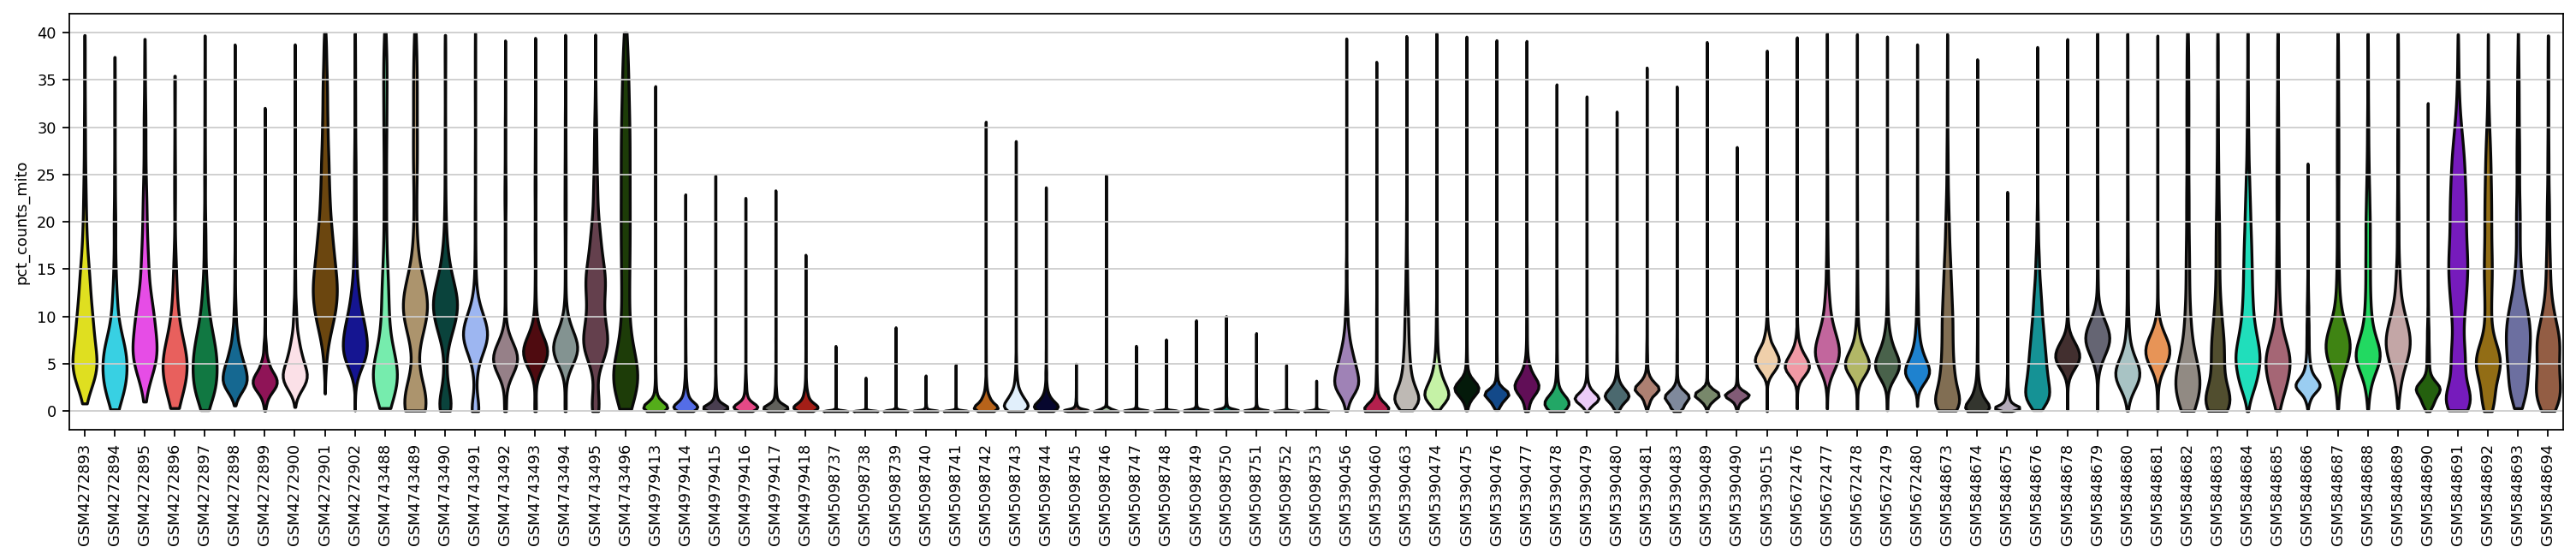

In [65]:
sc.settings.set_figure_params(
    fontsize=8,
    figsize=[18,4]
)

sc.pl.violin(
    scm,
    size=0.5,
    rotation=90,
#     log=True,
    keys=['pct_counts_mito'],# '',''],
    stripplot=False,
    groupby='GSM.accession'
)

Preprocessing...

In [32]:
sc.pp.normalize_total(
    scm, 
    target_sum=1e4
)

sc.pp.log1p(
    scm
)

sc.pp.highly_variable_genes(
    scm,
    subset=False
)

In [34]:
sc.pp.scale(
    scm
)
sc.tl.pca(
    scm, 
    svd_solver='arpack',
    n_comps=50
)

In [66]:
scm.shape

(456282, 61860)

In [39]:
sc.pp.neighbors(
    scm,
    n_pcs = npcs(scm, reduction="X_pca"),
    n_neighbors = 50
)

In [41]:
sc.tl.umap(
    scm
#     group_by ="neighbors"
)

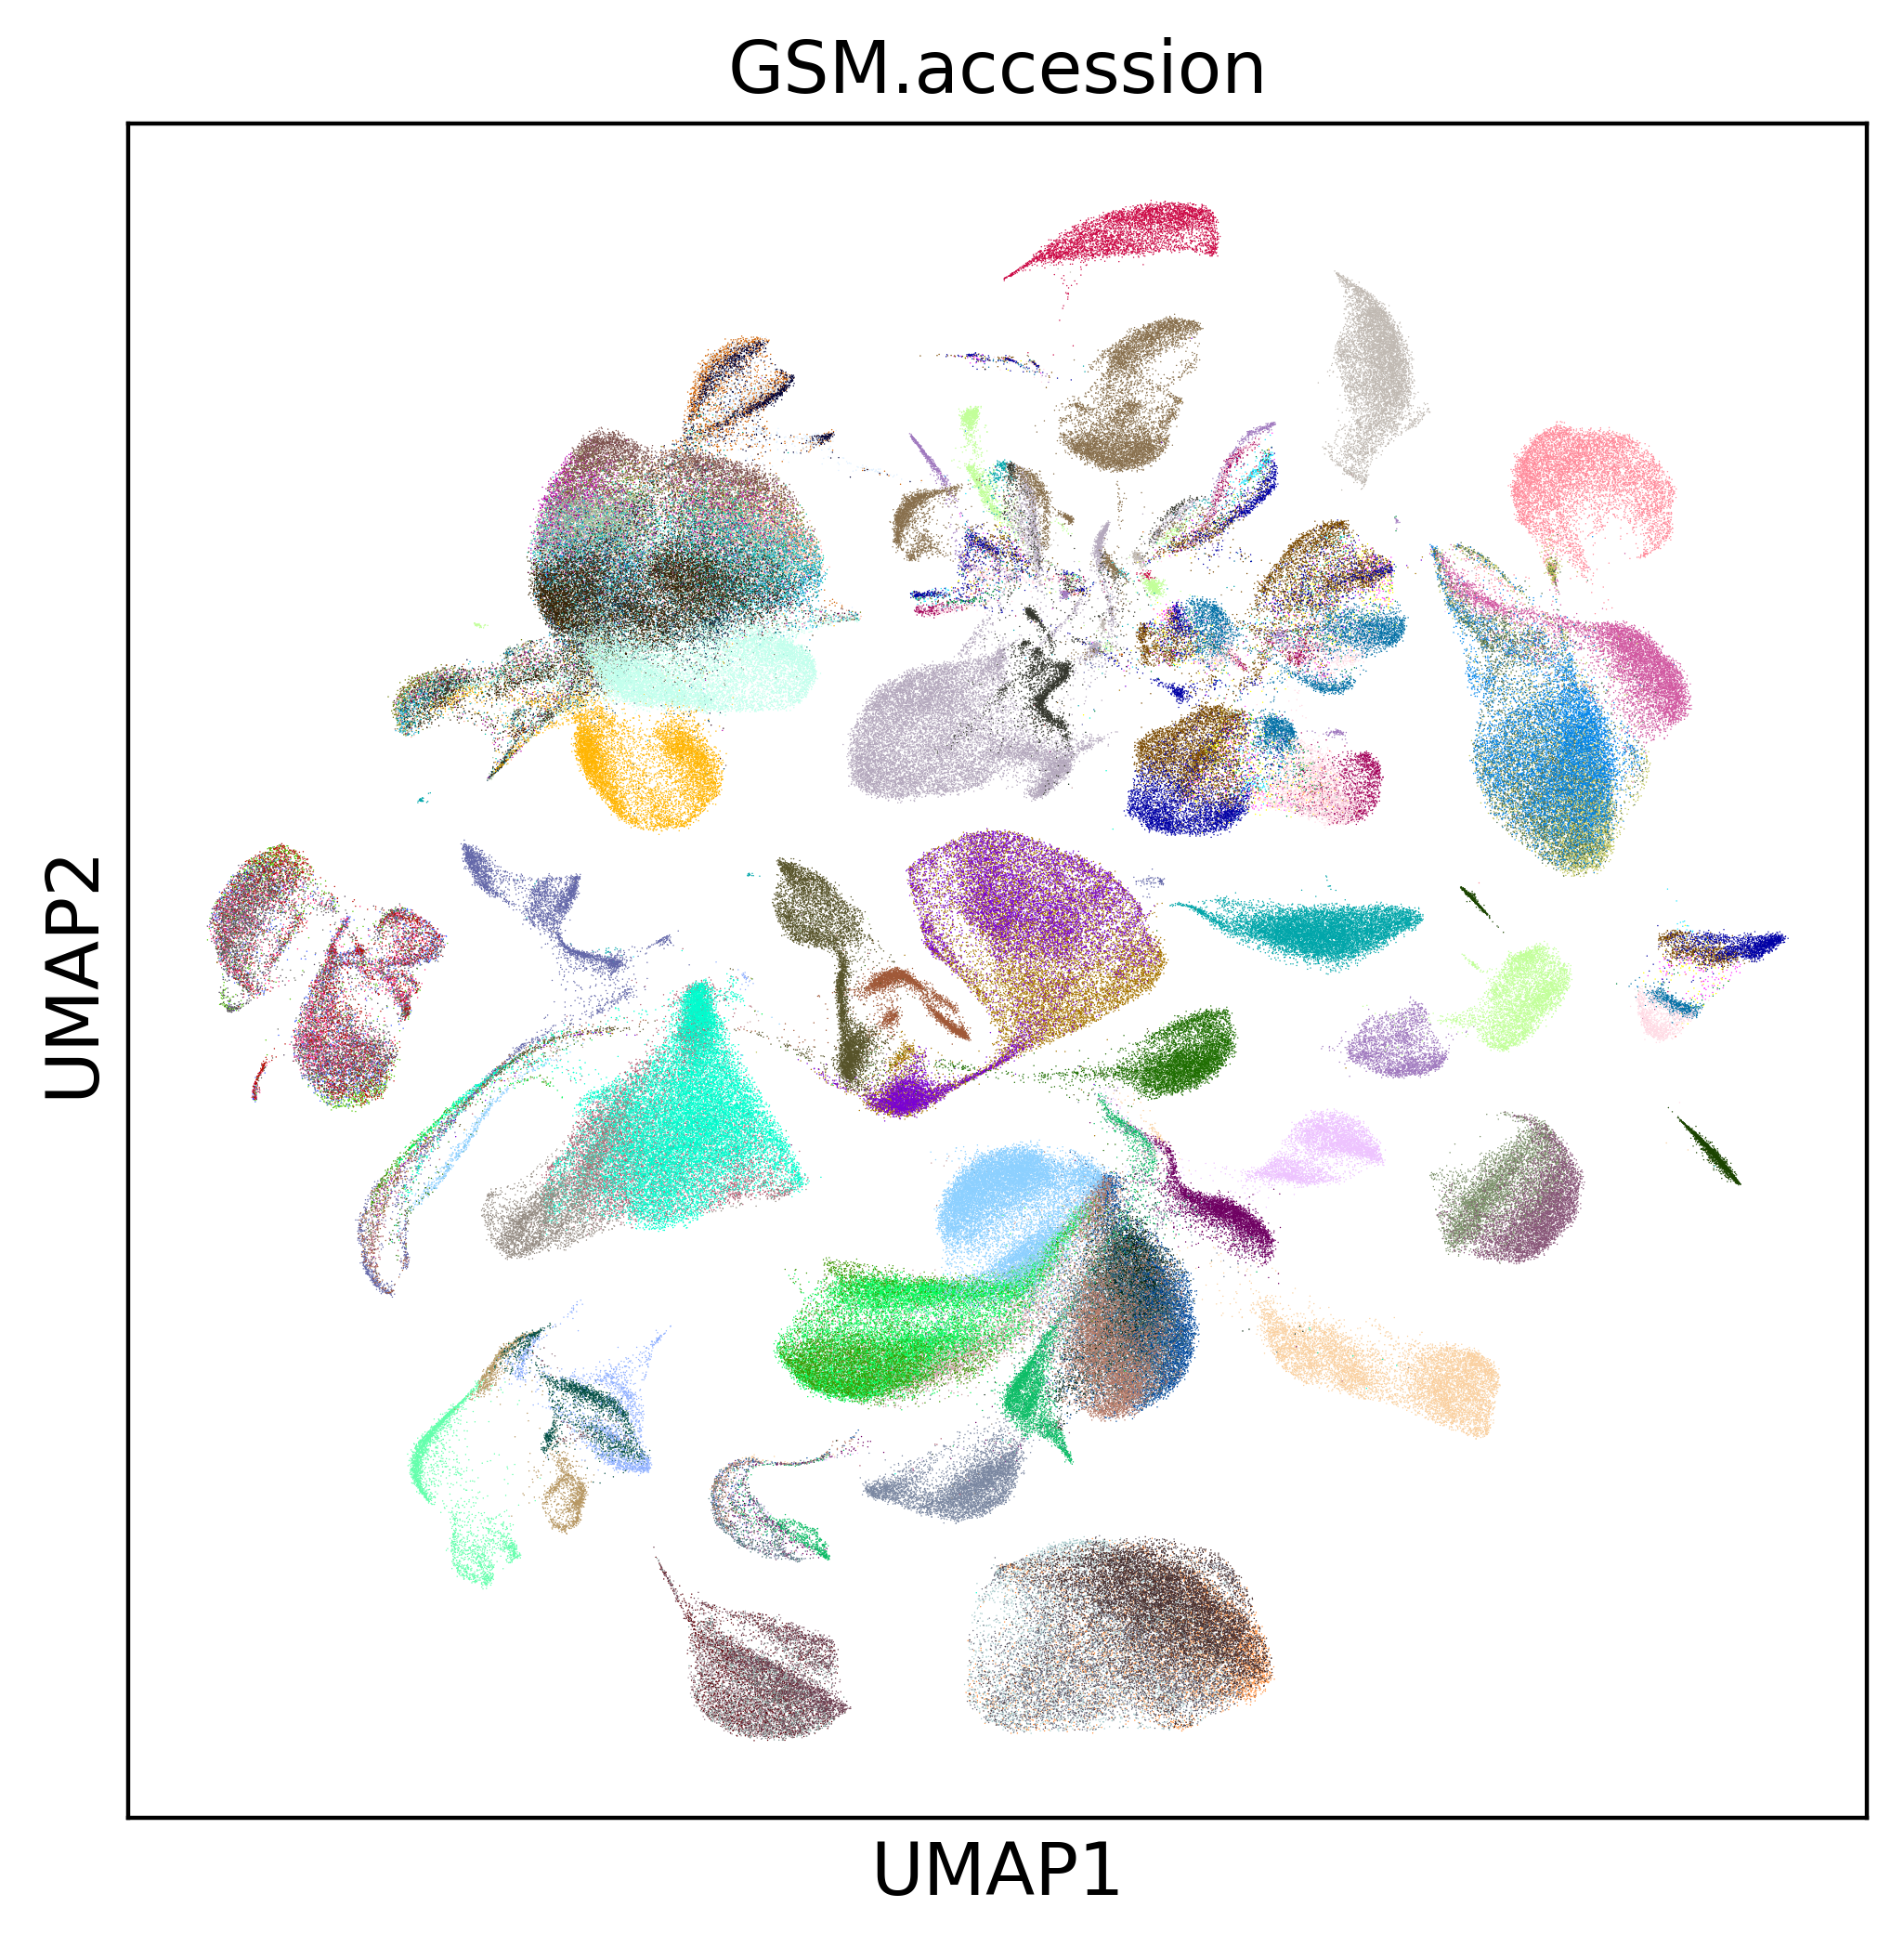

In [70]:
sc.set_figure_params(
    figsize=(6,6),
    dpi=200
)
sc.pl.umap(
    scm,
    legend_loc = None,
    color =["GSM.accession"] #GSM.accession
)

In [72]:
gc.collect()

0

Add cell cycle inference

In [68]:
# load in cell cycle genes lists
s_genes = list(pd.read_csv("resources/gene_lists/seurat_s_genes_2019.csv")['x'])
g2m_genes = list(pd.read_csv("resources/gene_lists/seurat_g2m_genes_2019.csv")['x'])

# score and plot
sc.tl.score_genes_cell_cycle(
    scm, 
    s_genes=s_genes, 
    g2m_genes=g2m_genes, 
    use_raw=False
)

Save merged anndata object for easy loading

In [74]:
# Save h5ad object for subsequent python analyses
scm.write("data/pyobjs/homo_sapiens_v1.h5ad")